## Overview
The city of GreenCity has been struggling with waste management, especially in distinguishing between recyclable and organic waste. The local waste management organization, EcoClean, is tasked with improving the efficiency of waste sorting. However, the current manual process is both time-consuming and error-prone. To enhance the system, EcoClean wants you to develop an AI-powered solution that can automatically classify waste products using image recognition techniques. This project aims to build a model that can differentiate between recyclable and organic waste products using transfer learning.

## Background
EcoClean currently lacks an efficient and scalable method to automate the waste sorting process. The manual sorting of waste is not only labor-intensive but also prone to errors, leading to contamination of recyclable materials. The goal of this project is to leverage machine learning and computer vision to automate the classification of waste products, improving efficiency and reducing contamination rates. The project will use transfer learning with a pre-trained VGG16 model to classify images.

## Objectives
After completing this project, you will be able to:

- Apply transfer learning using the VGG16 model for image classification
- Prepare and preprocess image data for a machine learning task
- Fine-tune a pre-trained model to improve classification accuracy
- Evaluate the model's performance using appropriate metrics
- Visualize model predictions on test data


In [4]:
!pip install tensorflow==2.17.0 | tail -n 1
!pip install numpy==1.26.0 | tail -n 1
!pip install scikit-learn==1.5.1  | tail -n 1
!pip install matplotlib==3.9.2  | tail -n 1
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


### Import required libraries


In [5]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## <a id='toc1_5_'></a>[Background](#toc0_)


**Transfer learning** uses the concept of keeping the early layers of a pre-trained network, and re-training the later layers on a specific dataset. You can leverage some state of that network on a related task.

A typical transfer learning workflow in Keras looks something like this:

1.  Initialize base model, and load pre-trained weights (e.g. ImageNet)
2.  "Freeze" layers in the base model by setting `training = False`
3.  Define a new model that goes on top of the output of the base model's layers.
4.  Train resulting model on your data set.

## <a id='toc1_6_'></a>[Create a model for distinguishing recyclable and organic waste images](#toc0_)

### <a id='toc1_6_1_'></a>[Dataset](#toc0_)

You will be using the [Waste Classification Dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).

Your goal is to train an algorithm on these images and to predict the labels for images in your test set (1 = recyclable, 0 = organic).

### <a id='toc1_6_2_'></a>[Importing Data](#toc0_)

This will create a `o-vs-r-split` directory in your environment.

In [6]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 4988.63file/s]

Finished extracting file
Finished extracting file


### <a id='toc1_6_3_'></a>[Define configuration options](#toc0_)

It's time to define some model configuration options.

*   **batch size** is set to 32.
*   The **number of classes** is 2.
*   You will use 20% of the data for **validation** purposes.
*   You have two **labels** in your dataset: organic (O), recyclable (R).


In [7]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

### <a id='toc1_6_4_'></a>[Loading Images using ImageGeneratorClass](#toc0_)

Transfer learning works best when models are trained on smaller datasets. 

The folder structure looks as follows:

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```


#### <a id='toc1_6_4_1_'></a>[ImageDataGenerators](#toc0_)


Now you will create ImageDataGenerators used for training, validation and testing.

Image data generators create batches of tensor image data with real-time data augmentation. The generators loop over the data in batches and are useful in feeding data to the training process. 



In [8]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [10]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


## Create a test_generator using the test_datagen object
- directory should be set to path_test.
- class_mode should be set to 'binary'.
- seed should be set to seed.
- batch_size should be set to batch_size.
- shuffle should be set to False.
- target_size should be set to (img_rows, img_cols).

In [11]:
test_generator = test_datagen.flow_from_directory(
        directory=path_test,
        class_mode='binary',
        seed=seed,
        batch_size=batch_size,
        shuffle=False,
        target_size=(img_rows, img_cols)
)

Found 200 images belonging to 2 classes.


Labels: ['O', 'O', 'O', 'O', 'O']


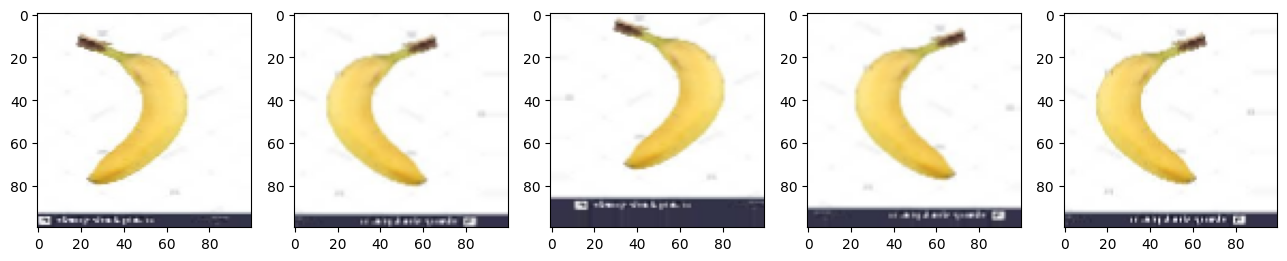

In [16]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

### Pre-trained models

In [17]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

